In [1]:
from bread.vis import *
from bread.data import Features, SegmentationFile, Microscopy
from bread.algo.lineage import LineageGuesser, LineageGuesserNN, LineageGuesserNearestCell, accuracy
from bread.data import Lineage

import pandas as pd
import numpy as np
import pathlib
import os
from sklearn.preprocessing import MinMaxScaler

In [2]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

## define functions to extract features in batches


In [3]:
# required functions for feature extraction
def extract_features(segmentation, guesser):
    candidate_features = pd.DataFrame()
    bud_ids, time_ids = segmentation.find_buds(
    ).bud_ids, segmentation.find_buds().time_ids
    f_list = []
    for i, (bud_id, time_id) in enumerate(zip(bud_ids, time_ids)):
        frame_range = guesser.segmentation.request_frame_range(
            time_id, time_id + guesser.num_frames)
        num_frames_available = guesser.num_frames
        if len(frame_range) < 2:
            # not enough frames
            continue
        if len(frame_range) < guesser.num_frames:
            num_frames_available = len(frame_range)

        # check the bud still exists !
        for time_id_ in frame_range:
            if bud_id not in guesser.segmentation.cell_ids(time_id_):
                # bud has disappeared
                continue
        selected_times = [i for i in range(
            time_id, time_id + num_frames_available)]
        try:
            candidate_parents = guesser._candidate_parents(
                time_id, nearest_neighbours_of=bud_id)
            for c_id, candidate in enumerate(candidate_parents):
                features, f_list = guesser._get_features(
                    bud_id, candidate, time_id, selected_times)
                new_row = {'bud_id': bud_id,
                           'candid_id': candidate, 'time_id': time_id}
                new_row.update(features)
                new_df = pd.DataFrame(new_row, index=[0])
                candidate_features = pd.concat([candidate_features, new_df])
        except Exception as e:
            # print("Error for bud {} at time {} with candidate: {}".format(
            #     bud_id, time_id, e))
            pass
    return candidate_features, f_list

# turn features in to a matrix format


def get_custom_matrix_features(features_all, lineage_gt, feature_list, filling_features=[-100 for i in range(100)]):
    # Generate np array of feature sets for each bud
    lineage = lineage_gt.copy()
    # remove the rows with parent_GT = -1 (no parent) and the rows with candid_GT = -2 (disappearing buds)
    lineage = lineage.loc[lineage.parent_GT != -1]
    lineage = lineage.loc[lineage.parent_GT != -2]
    lineage = lineage.loc[lineage.parent_GT != -3]
    candidate_features = features_all.copy()
    features_list = []
    filling_features = filling_features[:len(feature_list)]
    parent_index_list = []
    candidate_list = []
    for bud, colony in lineage[['bud_id', 'colony']].values:
        bud_data = candidate_features.loc[(candidate_features['bud_id'] == bud) & (
            candidate_features['colony'] == colony)]
        candidates = bud_data['candid_id'].to_numpy()
        features = bud_data[feature_list].to_numpy()
        if (len(candidates) == 0):
            if (len(bud_data) == 0):
                # bud only appears in the last frame
                lineage.drop(lineage.loc[(lineage['bud_id'] == bud) & (lineage.colony == colony)].index,
                             inplace=True)
            else:
                print('no candidates', bud, colony, candidates)
            continue
        elif candidates.shape[0] < 4:
            n_rows = 4 - candidates.shape[0]
            if candidates.shape[0] == 1:
                # only one candidate
                # fill with -100
                candidates = np.concatenate(
                    (candidates, np.array([-3 for i in range(n_rows)])), axis=0)
                features = np.concatenate(
                    (features, np.full((n_rows, features.shape[1]), -100)), axis=0)
            else:  # more than one candidate
                parent = int(lineage.loc[(lineage['bud_id'] == bud) & (
                    lineage['colony'] == colony), 'parent_GT'].iloc[0])
                not_parent_data = candidate_features.loc[(candidate_features['bud_id'] == bud) & (
                    candidate_features['colony'] == colony) & (candidate_features['candid_id'] != parent)]
                filling_features = not_parent_data[feature_list].to_numpy()[0]
                features = np.concatenate(
                    (features, [filling_features for i in range(n_rows)]), axis=0)
                candidates = np.concatenate(
                    (candidates, [-3 for i in range(n_rows)]), axis=0)
        elif features.shape[0] > 4:
            sorted_indices = np.argsort(features[:, 0])
            # print('more than 4 candidates', bud, colony, candidates, sorted_indices, int(lineage.loc[(lineage['bud_id'] == bud) & (
            #     lineage['colony'] == colony), 'parent_GT']))
            # slice the top 4 rows
            features = features[sorted_indices[:4]]
            candidates = candidates[sorted_indices[:4]]

        parent = int(lineage.loc[(lineage['bud_id'] == bud) & (
            lineage['colony'] == colony), 'parent_GT'].iloc[0])
        if (parent not in candidates):
            # print('parent not in candidates', bud, colony, candidates, parent)
            lineage.drop(lineage.loc[(lineage['bud_id'] == bud) & (
                lineage.colony == colony)].index, inplace=True)
            continue
        else:
            parent_index = np.where(candidates == parent)[0][0]
        parent_index_list.append(parent_index)
        features_list.append(features)
        candidate_list.append(candidates)
    lineage['features'] = features_list
    lineage['candidates'] = candidate_list
    lineage['parent_index_in_candidates'] = parent_index_list
    return lineage

## define functions for training neural network


In [4]:
import itertools
import wandb
import torch.optim as optim
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler
import torch
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import os


class BudDataset(Dataset):
    def __init__(self, data, augment=True):
        X = data['features'].to_numpy()
        labels = data['parent_index_in_candidates'].to_numpy()
        if (augment):
            X, labels = generate_all_permutations(X, labels)
        X = flatten_3d_array(X)
        self.data = torch.tensor(X, dtype=torch.float32)
        self.labels = torch.zeros(len(labels), 4)  # initialize labels as zeros
        for i, label in enumerate(labels):
            if label != -1:
                # set the position of the correct parent to 1
                self.labels[i][label] = 1.0

    def __getitem__(self, index):
        data = self.data[index]
        return self.data[index], self.labels[index]

    def __len__(self):
        return len(self.labels)

# lineage NN with mask


class LineageNN(nn.Module):
    def __init__(self, layers):
        super(LineageNN, self).__init__()
        self.layers = nn.ModuleList()  # create an empty nn.ModuleList
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x):
        mask = (x != -100).float()
        x = x * mask  # apply the mask to zero out invalid values
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        x = self.layers[-1](x)
        return x


# functions to deal with data


def flatten_3d_array(arr):
    """
    Flattens a 3-dimensional numpy array while keeping the first dimension unchanged
    """
    if arr.ndim == 1:
        arr2 = np.array([arr[i] for i in range(len(arr))])
        arr = np.stack(arr2)
    shape = arr.shape
    new_shape = (shape[0], np.prod(shape[1:]))
    return arr.reshape(new_shape)


def permute_matrix(matrix, row_id):
    """
    Generates all possible permutations of a matrix  rows
    it takes row_index as input, which is a one-hot encoded label for the classification 
    and outputs the one-hot encoded labels of the permutated matrices
    """
    # Get the number of rows in the matrix
    rows = len(matrix)

    # Get all possible permutations of the row indices
    permutations = list(itertools.permutations(range(rows)))

    # Use list comprehension to create a list of all permuted matrices
    permuted_matrices = [np.array([matrix[i] for i in permutation])
                         for permutation in permutations]

    # Use list comprehension to find the index of the specified row in each permuted matrix
    row_indices = [list(permutation).index(row_id)
                   for permutation in permutations]

    return permuted_matrices, row_indices


def generate_all_permutations(data, labels):
    """
    Generates all posible permutations for matrices in data 
    and the corresponding labels
    Labels should be integers
    """

    permuted_matrices_list = []
    permuted_labels_list = []

    for matrix, label in zip(data, labels):
        permuted_matrices, permuted_labels = permute_matrix(matrix, label)
        permuted_matrices_list.extend(permuted_matrices)
        permuted_labels_list.extend(permuted_labels)

    return np.array(permuted_matrices_list), np.array(permuted_labels_list)

# functions to train and test the model


def train_nn(train_df, eval_df, save_path='bst_nn.pth', config={}, seed=42):
    # Initialize wandb
    use_wandb = config['use_wandb']
    if (use_wandb):
        wandb.init(project="lineage_tracing", group='with_mask', config=config)

    # initialize neural network
    # manualy set the seed to enable reproducibility
    torch.manual_seed(seed)
    net = LineageNN(layers=config['layers'])

    # define your loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=config['lr'])
    scheduler = lr_scheduler.LinearLR(
        optimizer, start_factor=1, end_factor=0.01, total_iters=200)

    train_bud_dataset = BudDataset(train_df, augment=config['augment'])
    train_bud_dataloader = DataLoader(
        train_bud_dataset, batch_size=config['batch_size'], shuffle=True)
    eval_bud_dataset = BudDataset(eval_df, augment=False)
    eval_bud_dataloader = DataLoader(
        eval_bud_dataset, batch_size=config['batch_size'], shuffle=True)

    # train your neural network
    patient = 0
    best_accuracy = 0.0
    for epoch in range(config['epoch_n']):
        running_loss = 0.0
        # training loop
        predicted_all = []
        labels_all = []
        net.train()
        for i, data in enumerate(train_bud_dataloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            # forward pass
            outputs = net(inputs)
            # calculate the loss
            loss = criterion(outputs, labels)
            _, labels = torch.max(labels.data, 1)
            _, predicted = torch.max(outputs.data, 1)
            predicted_all.extend(predicted)
            labels_all.extend(labels)
            # backward pass and optimize
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            scheduler.step()
        train_accuracy = accuracy_score(labels_all, predicted_all)
        # eval loop
        predicted_all = []
        labels_all = []
        net.eval()
        for i, data in enumerate(eval_bud_dataloader, 0):
            inputs, labels = data
            with torch.no_grad():
                outputs = net(inputs)
            _, labels = torch.max(labels.data, 1)
            _, predicted = torch.max(outputs.data, 1)
            predicted_all.extend(predicted)
            labels_all.extend(labels)
        eval_accuracy = accuracy_score(labels_all, predicted_all)
        if (eval_accuracy > best_accuracy):
            best_accuracy = eval_accuracy
            best_model = net
            torch.save(net.state_dict(), save_path)
            patient = 0
        else:
            patient += 1
        if (patient > config['patience']):
            print('early stopping at ', epoch, 'LR: ',
                  optimizer.param_groups[0]['lr'])
            break
        if (use_wandb):
            wandb_log = {'epoch': epoch, 'patience': patient, 'eval_accuracy': eval_accuracy,
                         'train_accuracy': train_accuracy, 'best_accuracy': best_accuracy, 'lr': optimizer.param_groups[0]['lr']}
            wandb.log(wandb_log)
    return best_model, best_accuracy


def test_nn(model, test_df):
    bud_dataset = BudDataset(test_df, augment=False)
    bud_dataloader = DataLoader(
        bud_dataset, batch_size=len(test_df), shuffle=False)
    for i, data in enumerate(bud_dataloader, 0):
        if (i > 0):
            print('more than one batch')
        inputs, labels = data
        with torch.no_grad():
            outputs = model(inputs)
        _, labels = torch.max(labels.data, 1)
        _, predicted = torch.max(outputs.data, 1)
        accuracy = accuracy_score(predicted, labels)
    print('test accuracy', accuracy)
    test_df['predicted'] = predicted
    return test_df, accuracy


def cv_nn(df, config={}, seed=42):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    X = df['features'].to_numpy()
    y = df['parent_index_in_candidates'].to_numpy()
    # repeat df because it necessary for the function to have two arguments
    skf.get_n_splits(X, y)
    accuracies = []
    models = []
    i = 0
    # repeat df because it necessary for the function to have two arguments
    for train_index, test_index in skf.split(X, y):
        i = i+1
        config['cv_number'] = i
        print('config: ', config)
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        net, accuracy = train_nn(train_df, test_df, config=config, seed=seed)
        accuracies.append(accuracy)
        models.append(net)

    print('accuracy: ', np.mean(accuracies), '+/-', np.std(accuracies))
    return models, accuracies

## A pipeline to train a neural network based on given arguments


defining the arguments and settings of the model

defining the arguments

In [5]:
# constant values and arguments
selected_keys = ['dist_0', 'dist_std', 'poly_fit_budcm_budpt', 'poly_fit_expansion_vector', 'position_bud_std', 'position_bud_max', 'position_bud_min', 'position_bud_last', 'position_bud_first',
                 'orientation_bud_std', 'orientation_bud_max', 'orientation_bud_min', 'orientation_bud_last', 'orientation_bud_first', 'orientation_bud_last_minus_first', 'plyfit_orientation_bud']
args = {'fov': 0, 'bud_distance_max': 12, 'num_frames': 8,
        'num_frames_refractory': 0, 'normalized': True, 'selected_keys': selected_keys}
# config for trianing neural network
config = {'owner': 'train_pipeline', 'epoch_n': 200, 'patience': 10, 'lr': 0.01, 'batch_size': 256, 'layers': [
    64, 64, 4], 'augment': True, 'features': selected_keys, 'dist_threshold': args['bud_distance_max'], 'num_frames': args['num_frames'], 'normalized': args['normalized'], 'use_wandb': False}
res = {}

### Loading ground truth lineage tracing data and the corresponding mask files

In [6]:
# load ground truth data
ground_truth_path = [
    '~/Documents/LPBS/LPBS_track_and_trace_sahand_data/Data_budding_yeast/recording_1/colony001_lineage_gt.csv',
    '~/Documents/LPBS/LPBS_track_and_trace_sahand_data/Data_budding_yeast/recording_2/colony002_lineage_gt.csv',
    '~/Documents/LPBS/LPBS_track_and_trace_sahand_data/Data_budding_yeast/recording_3/colony003_lineage_gt.csv',
    '~/Documents/LPBS/LPBS_track_and_trace_sahand_data/Data_budding_yeast/recording_4/colony004_lineage_gt.csv',
    '~/Documents/LPBS/LPBS_track_and_trace_sahand_data/Data_budding_yeast/recording_6_validation/colony000_lineage_gt.csv',
    '~/Documents/LPBS/LPBS_track_and_trace_sahand_data/Data_budding_yeast/recording_7_test/colony005_lineage_gt.csv',
    '~/Documents/LPBS/LPBS_track_and_trace_sahand_data/Data_budding_yeast/recording_external/colony_external_006_lineage_gt.csv',
]
lin_gt_all = pd.DataFrame()
for lineage_gt_path in ground_truth_path:
    lin_truth = pd.read_csv(lineage_gt_path)
    lin_truth['colony'] = lineage_gt_path.split('/')[-2].split('_')[1]
    lin_gt_all = pd.concat([lin_gt_all, lin_truth])
lin_gt_all.rename(columns={'# parent_id': 'parent_GT'}, inplace=True)
lin_gt_external = lin_gt_all.loc[lin_gt_all['colony']
                                 == 'external'].reset_index(drop=True)
lin_gt_all = lin_gt_all.loc[lin_gt_all['colony'] != 'external']
lin_gt_all.reset_index(inplace=True, drop=True)

In [8]:
# extracting features and normalizing them if required
features_all = pd.DataFrame()
segmentation_files = [
    '/Users/farzanehwork/Documents/LPBS/LPBS_track_and_trace_sahand_data/Data_budding_yeast/Recording_1/colony001_segmentation.h5',
    '/Users/farzanehwork/Documents/LPBS/LPBS_track_and_trace_sahand_data/Data_budding_yeast/Recording_2/colony002_segmentation.h5',
    '/Users/farzanehwork/Documents/LPBS/LPBS_track_and_trace_sahand_data/Data_budding_yeast/Recording_3/colony003_segmentation.h5',
    '/Users/farzanehwork/Documents/LPBS/LPBS_track_and_trace_sahand_data/Data_budding_yeast/Recording_4/colony004_segmentation.h5',
    '/Users/farzanehwork/Documents/LPBS/LPBS_track_and_trace_sahand_data/Data_budding_yeast/Recording_6_validation/segmentation_colony000_corrected_last_frames_removed.h5',
    '/Users/farzanehwork/Documents/LPBS/LPBS_track_and_trace_sahand_data/Data_budding_yeast/Recording_7_test/colony005_segmentation.h5',
    # '/Users/farzanehwork/Documents/LPBS/LPBS_track_and_trace_sahand_data/Data_budding_yeast/Recording_external/colony006_segmentation.h5',
]
for segmentation_file in segmentation_files:
    colony = segmentation_file.split('/')[-2].split('_')[1]
    print(f'Processing colony {colony}')
    segmentation = SegmentationFile.from_h5(
        segmentation_file).get_segmentation('FOV'+str(args['fov']))
    guesser = LineageGuesserNN(
        segmentation=segmentation,
        nn_threshold=args['bud_distance_max'],
        num_frames_refractory=args['num_frames_refractory'],
        num_frames=args['num_frames'],
    )
    features, f_list = extract_features(segmentation, guesser)
    features['colony'] = colony
    features_all = pd.concat([features_all, features])
X = features_all[selected_keys]
scaler = MinMaxScaler()
# save this scaler to use it later for normalization
X_norm = scaler.fit_transform(X)
if (args['normalized']):
    # normalize features
    features_all_normalized = features_all.copy()
    features_all_normalized[selected_keys] = X_norm
    features_all = features_all_normalized

# makes feature for external data
colony = 'external'
print(f'Processing colony {colony}')
segmentation = SegmentationFile.from_h5(
    '/Users/farzanehwork/Documents/LPBS/LPBS_track_and_trace_sahand_data/Data_budding_yeast/Recording_external/colony006_segmentation.h5').get_segmentation('FOV'+str(args['fov']))
guesser = LineageGuesserNN(
    segmentation=segmentation,
    nn_threshold=args['bud_distance_max'],
    num_frames_refractory=args['num_frames_refractory'],
    num_frames=args['num_frames'],
)
features_external, f_list = extract_features(segmentation, guesser)
features_external['colony'] = colony
features_external[selected_keys] = scaler.transform(
    features_external[selected_keys])

Processing colony 1
removing small particles with less than 9 pixels that probably have been mis-segmented


/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/data/_data.py:63: UserWarning: Lineage.confidence initialized with non-float, int64 used.
  warnings.warn(f'Lineage.confidence initialized with non-float, {self.confidence.dtype} used.')


Processing colony 2
removing small particles with less than 9 pixels that probably have been mis-segmented


/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/data/_data.py:63: UserWarning: Lineage.confidence initialized with non-float, int64 used.
  warnings.warn(f'Lineage.confidence initialized with non-float, {self.confidence.dtype} used.')


Processing colony 3
removing small particles with less than 9 pixels that probably have been mis-segmented


/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/data/_data.py:63: UserWarning: Lineage.confidence initialized with non-float, int64 used.
  warnings.warn(f'Lineage.confidence initialized with non-float, {self.confidence.dtype} used.')
/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/algo/lineage/_lineage.py:248: BreadWarning: cell #77 does not have nearest neighbours with a distance less than 12, and flexible_threshold is False.
  warnings.warn(BreadWarning(f'cell #{nearest_neighbours_of} does not have nearest neighbours with a distance less than {self.nn_threshold}, and flexible_threshold is {self.flexible_nn_threshold}.'))


Processing colony 4
removing small particles with less than 9 pixels that probably have been mis-segmented


/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/data/_data.py:63: UserWarning: Lineage.confidence initialized with non-float, int64 used.
  warnings.warn(f'Lineage.confidence initialized with non-float, {self.confidence.dtype} used.')
/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/algo/lineage/_lineage.py:248: BreadWarning: cell #114 does not have nearest neighbours with a distance less than 12, and flexible_threshold is False.
  warnings.warn(BreadWarning(f'cell #{nearest_neighbours_of} does not have nearest neighbours with a distance less than {self.nn_threshold}, and flexible_threshold is {self.flexible_nn_threshold}.'))


Processing colony 6
removing small particles with less than 9 pixels that probably have been mis-segmented


/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/data/_data.py:63: UserWarning: Lineage.confidence initialized with non-float, int64 used.
  warnings.warn(f'Lineage.confidence initialized with non-float, {self.confidence.dtype} used.')
/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/data/_data.py:753: MultipleContoursWarning: OpenCV returned multiple contours, 2 found.
  warnings.warn(Contour.MultipleContoursWarning(len(contours_cv)))


66 33


/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/algo/lineage/_lineage.py:248: BreadWarning: cell #44 does not have nearest neighbours with a distance less than 12, and flexible_threshold is False.
  warnings.warn(BreadWarning(f'cell #{nearest_neighbours_of} does not have nearest neighbours with a distance less than {self.nn_threshold}, and flexible_threshold is {self.flexible_nn_threshold}.'))
/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/data/_data.py:753: MultipleContoursWarning: OpenCV returned multiple contours, 2 found.
  warnings.warn(Contour.MultipleContoursWarning(len(contours_cv)))


111 6


/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/data/_data.py:753: MultipleContoursWarning: OpenCV returned multiple contours, 2 found.
  warnings.warn(Contour.MultipleContoursWarning(len(contours_cv)))


125 193


/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/data/_data.py:753: MultipleContoursWarning: OpenCV returned multiple contours, 4 found.
  warnings.warn(Contour.MultipleContoursWarning(len(contours_cv)))


146 249
Processing colony 7
removing small particles with less than 9 pixels that probably have been mis-segmented


/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/data/_data.py:63: UserWarning: Lineage.confidence initialized with non-float, int64 used.
  warnings.warn(f'Lineage.confidence initialized with non-float, {self.confidence.dtype} used.')


Processing colony external
removing small particles with less than 9 pixels that probably have been mis-segmented


/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/data/_data.py:63: UserWarning: Lineage.confidence initialized with non-float, int64 used.
  warnings.warn(f'Lineage.confidence initialized with non-float, {self.confidence.dtype} used.')
/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/algo/lineage/_lineage.py:248: BreadWarning: cell #269 does not have nearest neighbours with a distance less than 12, and flexible_threshold is False.
  warnings.warn(BreadWarning(f'cell #{nearest_neighbours_of} does not have nearest neighbours with a distance less than {self.nn_threshold}, and flexible_threshold is {self.flexible_nn_threshold}.'))
/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/algo/lineage/_lineage.py:248: BreadWarning: cell #290 does not have nearest neighbours with a distance less than 12, and flexible_threshold is False.
  warnings.warn(BreadWarning(f'cell #{nearest_neighbours_of} does not have nearest neighbours with a distance less than {

In [9]:
# save the normalizing scaler
import joblib
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [10]:
features_all

,bud_id,candid_id,time_id,dist_0,dist_max,dist_min,dist_std,dist_max_min,poly_fit_budcm_candidcm,poly_fit_budcm_budpt,...,position_bud_first,position_bud_last_minus_first,orientation_bud_std,orientation_bud_max,orientation_bud_min,orientation_bud_last,orientation_bud_first,orientation_bud_last_minus_first,plyfit_orientation_bud,colony
0,1,1,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023886,...,0.869896,0.031711,0.218151,0.973294,0.644704,0.849225,0.869216,0.020125,0.498841,1
0,1,2,0,0.148430,1.901010,1.344217,0.000763,0.556793,-0.034656,0.023903,...,0.586947,0.211131,0.062983,0.995843,0.903837,0.873061,0.943147,0.070267,0.506690,1
0,2,1,0,0.148430,1.901010,1.344217,0.000763,0.556793,-0.034656,0.022961,...,0.972797,0.204294,0.072220,0.712573,0.577346,0.690193,0.557116,0.132753,0.534611,1
0,2,2,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023627,...,0.086181,0.957792,0.460084,0.684625,0.029898,0.696057,0.085134,0.611314,0.632421,1
0,3,2,4,0.074215,2.688435,0.950505,0.001806,1.737930,1.579288,0.050740,...,0.295465,0.265127,0.537777,0.873630,0.057470,0.302709,0.054345,0.247775,0.519188,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,37,18,175,0.134782,1.929972,0.000000,0.002430,1.929972,1.165631,0.042387,...,0.994078,0.189110,0.830149,0.994807,0.000000,0.900860,0.719519,0.181325,0.566353,7
0,37,26,175,0.134782,1.726220,0.000000,0.002364,1.726220,1.016606,0.042194,...,0.994190,0.250445,0.736023,0.909494,0.000000,0.764863,0.842624,0.078075,0.488943,7
0,38,9,178,0.202173,2.589329,0.000000,0.003183,2.589329,0.667694,0.037549,...,0.598201,0.114891,0.637409,0.711104,0.000000,0.721580,0.534657,0.186714,0.651991,7
0,38,14,178,0.095305,2.441243,0.000000,0.003015,2.441243,1.653885,0.049533,...,0.751965,0.008933,0.890556,0.934335,0.000000,0.850944,0.936633,0.085918,0.462213,7


In [ ]:
# get matrix features
matrix_features = get_custom_matrix_features(
    features_all, lin_gt_all, selected_keys)
matrix_features.reset_index(inplace=True, drop=True)
# matrix features for external data
matrix_features_external = get_custom_matrix_features(
    features_external, lin_gt_external, selected_keys)
matrix_features_external.reset_index(inplace=True, drop=True)

In [13]:
all_buds = features_external.loc[features_external['time_id']
                                 != 0]['bud_id'].unique()
# find buds that are in all_buds but not in matrix_features_external
missing_buds = np.setdiff1d(
    all_buds, matrix_features_external['bud_id'].unique())
missing_buds

array([291, 292, 300, 306, 307, 309])

In [17]:
# split data into train and test
# split to train and test (5-fold cross validation take care of the rest)
test_df = matrix_features.sample(frac=0.2, random_state=3)
train_df = matrix_features.drop(test_df.index)

# train the model using 5-fold cross validation with fixed seed
models, accuracies = cv_nn(train_df, config=config, seed=42)
res['val_accuracy'] = np.mean(accuracies)
res['val_accuracy_std'] = np.std(accuracies)
# test all of the models fom 5-fold cv on the test set
accuracies_test = []
for model in models:
    pred, accuracy = test_nn(model, test_df)
    accuracies_test.append(accuracy)
res['internal_test_accuracy'] = np.mean(accuracies_test)
res['internal_test_accuracy_std'] = np.std(accuracies_test)

config:  {'owner': 'train_pipeline', 'epoch_n': 200, 'patience': 10, 'lr': 0.01, 'batch_size': 256, 'layers': [64, 64, 4], 'augment': True, 'features': ['dist_0', 'dist_std', 'poly_fit_budcm_budpt', 'poly_fit_expansion_vector', 'position_bud_std', 'position_bud_max', 'position_bud_min', 'position_bud_last', 'position_bud_first', 'orientation_bud_std', 'orientation_bud_max', 'orientation_bud_min', 'orientation_bud_last', 'orientation_bud_first', 'orientation_bud_last_minus_first', 'plyfit_orientation_bud'], 'dist_threshold': 12, 'num_frames': 8, 'normalized': True, 'use_wandb': False, 'cv_number': 1}
early stopping at  15 LR:  9.99999999999999e-05
config:  {'owner': 'train_pipeline', 'epoch_n': 200, 'patience': 10, 'lr': 0.01, 'batch_size': 256, 'layers': [64, 64, 4], 'augment': True, 'features': ['dist_0', 'dist_std', 'poly_fit_budcm_budpt', 'poly_fit_expansion_vector', 'position_bud_std', 'position_bud_max', 'position_bud_min', 'position_bud_last', 'position_bud_first', 'orientation_b

In [18]:
res

{'val_accuracy': 0.8876582700253233,
 'val_accuracy_std': 0.03004867173353206,
 'internal_test_accuracy': 0.8987012987012987,
 'internal_test_accuracy_std': 0.003181155510108052}

In [34]:
# save the best model
best_model = 0
best_sum_accuracy = 0
for model in models:
    _, test_accuracy = test_nn(model, test_df)
    _, train_accuracy = test_nn(model, train_df)
    if (train_accuracy+test_accuracy > best_sum_accuracy):
        best_model = model
        best_sum_accuracy = train_accuracy+test_accuracy
torch.save(best_model.state_dict(), 'best_model_with_fake_candid_thresh{}_frame_num{}_normalized_{}.pth'.format(
    args['bud_distance_max'], args['num_frames'], args['normalized']))
print('best model saved :',  'best_model_fake_candid_thresh{}_frame_num{}_normalized_{}.pth'.format(
    args['bud_distance_max'], args['num_frames'], args['normalized']))

test accuracy 0.8961038961038961
test accuracy 0.8941368078175895
test accuracy 0.8961038961038961
test accuracy 0.8973941368078175
test accuracy 0.9025974025974026
test accuracy 0.8908794788273615
test accuracy 0.9025974025974026
test accuracy 0.8925081433224755
test accuracy 0.8961038961038961
test accuracy 0.8859934853420195
best model saved : best_model_fake_candid_thresh12_frame_num8_normalized_True.pth


In [35]:
# test best model on external data
pred_external, accuracy_external = test_nn(
    best_model, matrix_features_external)
print('external test accuracy', accuracy_external)

test accuracy 0.8503401360544217
external test accuracy 0.8503401360544217


In [21]:
len(matrix_features_external)

294

# Run a random forest on the same training data

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import numpy as np

# Prepare the data
X_train_full = np.array([np.array(x).flatten() for x in train_df['features']])
y_train_full = train_df['parent_index_in_candidates'].reset_index(drop=True)
X_test = np.array([np.array(x).flatten() for x in test_df['features']])
y_test = test_df['parent_index_in_candidates']

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=4)

# Initialize the model
rf = RandomForestClassifier(n_estimators=150, random_state=4)

# Store accuracies for validation and test
validation_accuracies = []
test_accuracies = []


# Perform 5-fold cross-validation
for train_index, val_index in kf.split(X_train_full):
    # Split the data into training and validation for the current fold
    X_train_fold, X_val_fold = X_train_full[train_index], X_train_full[val_index]
    y_train_fold, y_val_fold = y_train_full[train_index], y_train_full[val_index]

    # Train the model on the training fold
    rf.fit(X_train_fold, y_train_fold)

    # Evaluate on the validation fold
    y_val_pred = rf.predict(X_val_fold)
    val_accuracy = accuracy_score(y_val_fold, y_val_pred)
    validation_accuracies.append(val_accuracy)

    # Evaluate on the fixed test set
    y_test_pred = rf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)

# Calculate mean and standard deviation for validation and test accuracies
val_mean = np.mean(validation_accuracies)
val_std = np.std(validation_accuracies)

test_mean = np.mean(test_accuracies)
test_std = np.std(test_accuracies)

print('Validation accuracies for each fold:', validation_accuracies)
print('Mean validation accuracy:', val_mean)
print('Standard deviation of validation accuracy:', val_std)

print('Test accuracies for each fold:', test_accuracies)
print('Mean test accuracy:', test_mean)
print('Standard deviation of test accuracy:', test_std)

# test on external data
X_external = np.array([np.array(x).flatten()
                       for x in matrix_features_external['features']])
y_external = matrix_features_external['parent_index_in_candidates']
y_external_pred = rf.predict(X_external)
external_accuracy = accuracy_score(y_external, y_external_pred)
print('External test accuracy:', external_accuracy)

Validation accuracies for each fold: [0.8699186991869918, 0.8943089430894309, 0.8292682926829268, 0.9105691056910569, 0.8524590163934426]
Mean validation accuracy: 0.8713048114087698
Standard deviation of validation accuracy: 0.028965597122470925
Test accuracies for each fold: [0.8701298701298701, 0.8831168831168831, 0.8896103896103896, 0.8441558441558441, 0.8701298701298701]
Mean test accuracy: 0.8714285714285713
Standard deviation of test accuracy: 0.015584415584415603
External test accuracy: 0.8367346938775511


In [23]:
# test the random forest on the external test set

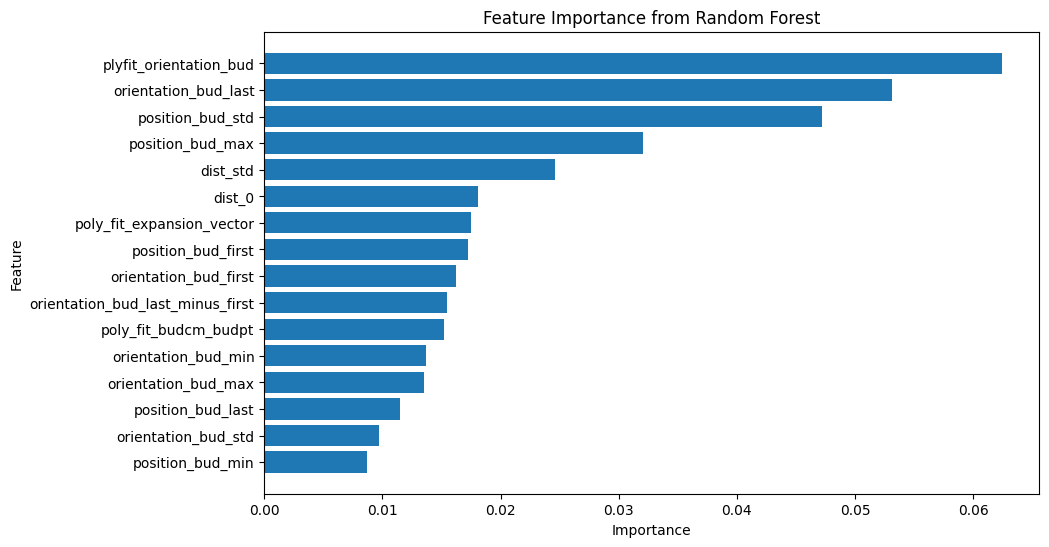

In [24]:
import matplotlib.pyplot as plt

# Get feature importances
importances = rf.feature_importances_

# Get feature names
feature_names = selected_keys * 4  # Since each feature is repeated 4 times

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame(
    {'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(
    by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()

# Compare with nearest cell and lyn-trace-fluo

In [25]:
bud_colony_test = test_df[["bud_id", "colony",
                           "time_index", "candidates", "predicted", "parent_GT"]]
bud_colony_train = train_df[["bud_id", "colony",
                             "time_index", "candidates", "predicted", "parent_GT"]]
# test_df

In [26]:
from bread.data import SegmentationFile, Microscopy, Segmentation
from bread.algo.lineage import LineageGuesserNN, LineageGuesserNearestCell, LineageGuesserBudLum, accuracy
from bread.data import Lineage

### Calculate accuracy of the lyn-trace-fluo method on the test set

In [27]:
budlum_files = [
    '/Users/farzanehwork/Documents/LPBS/LPBS_track_and_trace_sahand_data/Data_budding_yeast/Recording_1/colony001_GFP.tif',
    '/Users/farzanehwork/Documents/LPBS/LPBS_track_and_trace_sahand_data/Data_budding_yeast/Recording_2/colony002_GFP.tif',
    '/Users/farzanehwork/Documents/LPBS/LPBS_track_and_trace_sahand_data/Data_budding_yeast/Recording_3/colony003_GFP.tif',
    '/Users/farzanehwork/Documents/LPBS/LPBS_track_and_trace_sahand_data/Data_budding_yeast/Recording_4/colony004_GFP.tif',
    '/Users/farzanehwork/Documents/LPBS/LPBS_track_and_trace_sahand_data/Data_budding_yeast/Recording_6_validation/colony000_GFP.tif',
    '/Users/farzanehwork/Documents/LPBS/LPBS_track_and_trace_sahand_data/Data_budding_yeast/Recording_7_test/colony005_GFP.tif',
]
lin_guess_all_f = pd.DataFrame()
# Initialize the Lineage
for segmentation, fleu_marker_path, lineage_gt in zip(segmentation_files, budlum_files, ground_truth_path[:-1]):
    colony = segmentation.split('/')[-2].split('_')[1]
    print(f'Processing colony {colony}')
    segmentation = SegmentationFile.from_h5(
        segmentation).get_segmentation('FOV'+str(args['fov']))
    # lineage_gt = pd.read_csv(lineage_gt)
    microscopy = Microscopy.from_tiff(fleu_marker_path)['FOV0']
    # lineage_gt['colony'] = colony
    # lineage_gt.rename(columns={'# parent_id': 'parent_GT'}, inplace=True)
    # lineage_gt.reset_index(inplace=True, drop=True)
    # Initialize the LineageGuesserBudLum
    lineage_guess_budlum = LineageGuesserBudLum(
        budneck_img=microscopy, segmentation=segmentation).guess_lineage()
    lineage_guess_budlum_df = pd.DataFrame()
    lineage_guess_budlum_df['bud_id'] = lineage_guess_budlum.bud_ids
    lineage_guess_budlum_df['time_index'] = lineage_guess_budlum.time_ids
    lineage_guess_budlum_df['parent_guess'] = lineage_guess_budlum.parent_ids
    lineage_guess_budlum_df['colony'] = colony
    lin_guess_all_f = pd.concat([lin_guess_all_f, lineage_guess_budlum_df])
lin_guess_all_f.reset_index(inplace=True, drop=True)
lin_guess_all_f

Processing colony 1
removing small particles with less than 9 pixels that probably have been mis-segmented


/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/data/_data.py:63: UserWarning: Lineage.confidence initialized with non-float, int64 used.
  warnings.warn(f'Lineage.confidence initialized with non-float, {self.confidence.dtype} used.')
/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/algo/lineage/_lineage.py:302: NotEnoughFramesWarning: Not enough frames in the movie (bud #76 at frame #174), requested 8, but only 7 remaining.
  warnings.warn(NotEnoughFramesWarning(bud_id, time_id, self.num_frames, len(frame_range)))
/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/algo/lineage/_lineage.py:302: NotEnoughFramesWarning: Not enough frames in the movie (bud #77 at frame #175), requested 8, but only 6 remaining.
  warnings.warn(NotEnoughFramesWarning(bud_id, time_id, self.num_frames, len(frame_range)))
/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/algo/lineage/_lineage.py:302: NotEnoughFramesWarning: Not enough frames in the movi

Processing colony 2
removing small particles with less than 9 pixels that probably have been mis-segmented


/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/data/_data.py:63: UserWarning: Lineage.confidence initialized with non-float, int64 used.
  warnings.warn(f'Lineage.confidence initialized with non-float, {self.confidence.dtype} used.')
/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/algo/lineage/_lineage.py:302: NotEnoughFramesWarning: Not enough frames in the movie (bud #147 at frame #174), requested 8, but only 7 remaining.
  warnings.warn(NotEnoughFramesWarning(bud_id, time_id, self.num_frames, len(frame_range)))
/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/algo/lineage/_lineage.py:302: NotEnoughFramesWarning: Not enough frames in the movie (bud #148 at frame #175), requested 8, but only 6 remaining.
  warnings.warn(NotEnoughFramesWarning(bud_id, time_id, self.num_frames, len(frame_range)))
/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/algo/lineage/_lineage.py:302: NotEnoughFramesWarning: Not enough frames in the mo

Processing colony 3
removing small particles with less than 9 pixels that probably have been mis-segmented


/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/data/_data.py:63: UserWarning: Lineage.confidence initialized with non-float, int64 used.
  warnings.warn(f'Lineage.confidence initialized with non-float, {self.confidence.dtype} used.')
/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/algo/lineage/_lineage.py:314: LineageWarning: Unable to determine parent, got exception CellMissingException('Unable to find cell_id=60 at time_id=154 in the segmentation.'). Computation for frame #154, bud #60 skipped.
  warnings.warn(LineageWarning(f'Unable to determine parent, got exception {repr(e)}. Computation for frame #{time_id_}, bud #{bud_id} skipped.'))
/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/algo/lineage/_lineage.py:248: BreadWarning: cell #77 does not have nearest neighbours with a distance less than 8, and flexible_threshold is False.
  warnings.warn(BreadWarning(f'cell #{nearest_neighbours_of} does not have nearest neighbours with a dista

Processing colony 4
removing small particles with less than 9 pixels that probably have been mis-segmented


/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/data/_data.py:63: UserWarning: Lineage.confidence initialized with non-float, int64 used.
  warnings.warn(f'Lineage.confidence initialized with non-float, {self.confidence.dtype} used.')
/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/algo/lineage/_lineage.py:314: LineageWarning: Unable to determine parent, got exception CellMissingException('Unable to find cell_id=40 at time_id=124 in the segmentation.'). Computation for frame #124, bud #40 skipped.
  warnings.warn(LineageWarning(f'Unable to determine parent, got exception {repr(e)}. Computation for frame #{time_id_}, bud #{bud_id} skipped.'))
/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/algo/lineage/_lineage.py:314: LineageWarning: Unable to determine parent, got exception CellMissingException('Unable to find cell_id=40 at time_id=125 in the segmentation.'). Computation for frame #125, bud #40 skipped.
  warnings.warn(LineageWarning(f'U

Processing colony 6
removing small particles with less than 9 pixels that probably have been mis-segmented


/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/data/_data.py:63: UserWarning: Lineage.confidence initialized with non-float, int64 used.
  warnings.warn(f'Lineage.confidence initialized with non-float, {self.confidence.dtype} used.')
/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/data/_data.py:753: MultipleContoursWarning: OpenCV returned multiple contours, 2 found.
  warnings.warn(Contour.MultipleContoursWarning(len(contours_cv)))


66 33


/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/algo/lineage/_lineage.py:248: BreadWarning: cell #44 does not have nearest neighbours with a distance less than 8, and flexible_threshold is False.
  warnings.warn(BreadWarning(f'cell #{nearest_neighbours_of} does not have nearest neighbours with a distance less than {self.nn_threshold}, and flexible_threshold is {self.flexible_nn_threshold}.'))
/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/algo/lineage/_lineage.py:314: LineageWarning: Unable to determine parent, got exception NoCandidateParentException('No candidate parents have been found for in frame #74.'). Computation for frame #74, bud #44 skipped.
  warnings.warn(LineageWarning(f'Unable to determine parent, got exception {repr(e)}. Computation for frame #{time_id_}, bud #{bud_id} skipped.'))
/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/algo/lineage/_lineage.py:314: LineageWarning: Unable to determine parent, got exception CellMis

111 6
125 193


/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/data/_data.py:753: MultipleContoursWarning: OpenCV returned multiple contours, 4 found.
  warnings.warn(Contour.MultipleContoursWarning(len(contours_cv)))


146 249


/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/algo/lineage/_lineage.py:314: LineageWarning: Unable to determine parent, got exception NoCandidateParentException('No candidate parents have been found for in frame #147.'). Computation for frame #147, bud #305 skipped.
  warnings.warn(LineageWarning(f'Unable to determine parent, got exception {repr(e)}. Computation for frame #{time_id_}, bud #{bud_id} skipped.'))
/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/algo/lineage/_lineage.py:314: LineageWarning: Unable to determine parent, got exception NoCandidateParentException('No candidate parents have been found for in frame #147.'). Computation for frame #147, bud #306 skipped.
  warnings.warn(LineageWarning(f'Unable to determine parent, got exception {repr(e)}. Computation for frame #{time_id_}, bud #{bud_id} skipped.'))
/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/algo/lineage/_lineage.py:314: LineageWarning: Unable to determine parent

Processing colony 7
removing small particles with less than 9 pixels that probably have been mis-segmented


/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/data/_data.py:63: UserWarning: Lineage.confidence initialized with non-float, int64 used.
  warnings.warn(f'Lineage.confidence initialized with non-float, {self.confidence.dtype} used.')
/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/algo/lineage/_lineage.py:302: NotEnoughFramesWarning: Not enough frames in the movie (bud #37 at frame #175), requested 8, but only 6 remaining.
  warnings.warn(NotEnoughFramesWarning(bud_id, time_id, self.num_frames, len(frame_range)))
/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/algo/lineage/_lineage.py:302: NotEnoughFramesWarning: Not enough frames in the movie (bud #38 at frame #178), requested 8, but only 3 remaining.
  warnings.warn(NotEnoughFramesWarning(bud_id, time_id, self.num_frames, len(frame_range)))


,bud_id,time_index,parent_guess,colony
0,1,0,-1,1
1,2,0,-1,1
2,3,4,2,1
3,4,7,1,1
4,5,27,4,1
...,...,...,...,...
871,34,164,22,7
872,35,166,13,7
873,36,169,18,7
874,37,175,3,7


In [28]:
filtered_lin_guess_all_f = lin_guess_all_f[lin_guess_all_f[['bud_id', 'colony']].apply(
    tuple, 1).isin(test_df[['bud_id', 'colony']].apply(tuple, 1))]
filtered_lin_guess_all_f.reset_index(drop=True, inplace=True)
filtered_lin_guess_all_f
comparison = pd.merge(filtered_lin_guess_all_f,
                      test_df, on=["colony", "bud_id"])
comparison = comparison[['bud_id', 'colony', 'parent_GT', 'parent_guess']]
# count number of rows with correct parent guess
correct = comparison[comparison['parent_GT'] == comparison['parent_guess']]
accuracy = len(correct)/len(comparison)
print('accuracy of lyn-trace-fluo on the test set:', accuracy)

accuracy of lyn-trace-fluo on the test set: 1.0


### Calculate accuracy of the Nearest Neighbor method on the test set

In [29]:
lin_guess_all_n = pd.DataFrame()
# Initialize the Lineage
for segmentation, lineage_gt in zip(segmentation_files, ground_truth_path[:-1]):
    colony = segmentation.split('/')[-2].split('_')[1]
    print(f'Processing colony {colony}')
    segmentation = SegmentationFile.from_h5(
        segmentation).get_segmentation('FOV'+str(args['fov']))

    lineage_guess_nn = LineageGuesserNearestCell(
        segmentation=segmentation).guess_lineage()
    lineage_guess_nn_df = pd.DataFrame()
    lineage_guess_nn_df['bud_id'] = lineage_guess_nn.bud_ids
    lineage_guess_nn_df['time_index'] = lineage_guess_nn.time_ids
    lineage_guess_nn_df['parent_guess'] = lineage_guess_nn.parent_ids
    lineage_guess_nn_df['colony'] = colony
    lin_guess_all_n = pd.concat([lin_guess_all_n, lineage_guess_nn_df])
lin_guess_all_n.reset_index(inplace=True, drop=True)
lin_guess_all_n

Processing colony 1
removing small particles with less than 9 pixels that probably have been mis-segmented


/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/data/_data.py:63: UserWarning: Lineage.confidence initialized with non-float, int64 used.
  warnings.warn(f'Lineage.confidence initialized with non-float, {self.confidence.dtype} used.')


Processing colony 2
removing small particles with less than 9 pixels that probably have been mis-segmented


/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/data/_data.py:63: UserWarning: Lineage.confidence initialized with non-float, int64 used.
  warnings.warn(f'Lineage.confidence initialized with non-float, {self.confidence.dtype} used.')


Processing colony 3
removing small particles with less than 9 pixels that probably have been mis-segmented


/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/data/_data.py:63: UserWarning: Lineage.confidence initialized with non-float, int64 used.
  warnings.warn(f'Lineage.confidence initialized with non-float, {self.confidence.dtype} used.')


Processing colony 4
removing small particles with less than 9 pixels that probably have been mis-segmented


/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/data/_data.py:63: UserWarning: Lineage.confidence initialized with non-float, int64 used.
  warnings.warn(f'Lineage.confidence initialized with non-float, {self.confidence.dtype} used.')


Processing colony 6
removing small particles with less than 9 pixels that probably have been mis-segmented


/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/data/_data.py:63: UserWarning: Lineage.confidence initialized with non-float, int64 used.
  warnings.warn(f'Lineage.confidence initialized with non-float, {self.confidence.dtype} used.')
/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/data/_data.py:753: MultipleContoursWarning: OpenCV returned multiple contours, 2 found.
  warnings.warn(Contour.MultipleContoursWarning(len(contours_cv)))


66 33
111 6
125 193


/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/data/_data.py:753: MultipleContoursWarning: OpenCV returned multiple contours, 4 found.
  warnings.warn(Contour.MultipleContoursWarning(len(contours_cv)))


146 249
Processing colony 7
removing small particles with less than 9 pixels that probably have been mis-segmented


/Users/farzanehwork/Documents/LPBS/codes/YeaZ-toolbox/src/bread/data/_data.py:63: UserWarning: Lineage.confidence initialized with non-float, int64 used.
  warnings.warn(f'Lineage.confidence initialized with non-float, {self.confidence.dtype} used.')


,bud_id,time_index,parent_guess,colony
0,1,0,-1,1
1,2,0,-1,1
2,3,4,2,1
3,4,7,1,1
4,5,27,4,1
...,...,...,...,...
871,34,164,22,7
872,35,166,13,7
873,36,169,18,7
874,37,175,18,7


In [30]:
filtered_lin_guess_all_n = lin_guess_all_n[lin_guess_all_n[['bud_id', 'colony']].apply(
    tuple, 1).isin(test_df[['bud_id', 'colony']].apply(tuple, 1))]
filtered_lin_guess_all_n.reset_index(drop=True, inplace=True)
filtered_lin_guess_all_n
comparison = pd.merge(filtered_lin_guess_all_n,
                      test_df, on=["colony", "bud_id"])
comparison = comparison[['bud_id', 'colony', 'parent_GT', 'parent_guess']]
# count number of rows with correct parent guess
correct = comparison[comparison['parent_GT'] == comparison['parent_guess']]
accuracy = len(correct)/len(comparison)
print('accuracy of Nearest Neighbor on the test set:', accuracy)

accuracy of Nearest Neighbor on the test set: 0.6493506493506493
